# Advantage Actor-Critic


In [19]:
!apt-get install -y xvfb

!pip install \
  gymnasium==0.26.3 \
  pygame \
  pytorch-lightning==1.6 \
  pyvirtualdisplay

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


#### Setup virtual display

In [13]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

#### Import the necessary code libraries

In [14]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from torch.distributions import Normal

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, NormalizeObservation

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [3]:
@torch.no_grad()
def test_env(env_name, policy, obs_rms, **kwargs):
  env = gym.make(env_name, **kwargs)
  env = RecordVideo(env, 'videos', episode_trigger=lambda e: True)
  env = NormalizeObservation(env)
  env.obs_rms = obs_rms
  policy = policy.to(device)

  for episode in range(10):
    done = False
    obs = env.reset()
    while not done:
      loc, scale = policy(obs)
      action = torch.normal(loc, scale)
      action = action.cpu().numpy()
      obs, _, done, _ = env.step(action)
  del env


def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the policy

In [3]:
class GradientPolicy(nn.Module):

  def __init__(self, in_features, out_dims, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc_mu = nn.Linear(hidden_size, out_dims)
    self.fc_std = nn.Linear(hidden_size, out_dims)

  def forward(self, x):
    x = torch.tensor(x).float().to(device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    loc = self.fc_mu(x)
    loc = torch.tanh(loc) * 2
    scale = self.fc_std(x)
    scale = F.softplus(scale) + 0.001
    return loc, scale

In [4]:
class ValueNet(nn.Module):

  def __init__(self, in_features, hidden_size=128):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, 1)
  
  def forward(self, x):
    x = torch.tensor(x).float().to(device)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

#### Create the environment

In [5]:
env = gym.make("Pendulum-v1")
# env = gym.make('MountainCarContinuous-v0')
env.reset()

array([ 0.24134934, -0.9704383 , -0.5410339 ], dtype=float32)

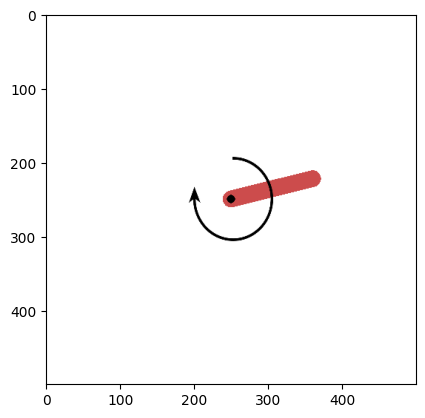

In [6]:
import matplotlib.pyplot as plt
plt.imshow(env.render(mode="rgb_array"))

In [7]:
env = gym.vector.make("Pendulum-v1", num_envs=2)

In [8]:
env.reset()

array([[-0.36552015,  0.9308034 ,  0.01482055],
       [ 0.9996916 , -0.02483243,  0.493078  ]], dtype=float32)

In [9]:
env.observation_space, env.action_space

(Box([[-1. -1. -8.]
  [-1. -1. -8.]], [[1. 1. 8.]
  [1. 1. 8.]], (2, 3), float32),
 Tuple(Box([-2.], [2.], (1,), float32), Box([-2.], [2.], (1,), float32)))

In [10]:
next_obs, rewards, dones, infos = env.step(env.action_space.sample())

In [11]:
infos

({}, {})

In [4]:
def create_env(env_name, num_envs):
  env = gym.vector.make(env_name, num_envs)
  env = RecordEpisodeStatistics(env)
  env = NormalizeObservation(env)
  return env

#### Create the dataset

In [13]:
class RLDataset(IterableDataset):

  def __init__(self, env, policy, steps_per_epoch):
    self.env = env
    self.policy = policy
    self.steps_per_epoch = steps_per_epoch
    self.obs = env.reset()

  @torch.no_grad()
  def __iter__(self):
    for step in range(self.steps_per_epoch):
      loc, scale = self.policy(self.obs)
      action = torch.normal(loc, scale)
      action = action.cpu().numpy()
      next_obs, reward, done, info = self.env.step(action)
      yield self.obs, action, reward, done, next_obs
      self.obs = next_obs

#### Create the A2C algorithm

In [21]:
class A2C(LightningModule):

  def __init__(self, env_name, num_envs=64, samples_per_epoch=8,
               batch_size=1, hidden_size=64, policy_lr=1e-4, value_lr=1e-3,
               gamma=0.99, entropy_coef=0.01, optim=AdamW):
    
    super().__init__()

    self.env = create_env(env_name, num_envs=num_envs)

    obs_size = self.env.single_observation_space.shape[0]
    action_dims = self.env.single_action_space.shape[0]

    self.policy = GradientPolicy(obs_size, action_dims, hidden_size)
    self.value_net = ValueNet(obs_size, hidden_size)
    self.target_value_net = copy.deepcopy(self.value_net)

    self.dataset = RLDataset(self.env, self.policy, samples_per_epoch)

    self.save_hyperparameters()

  def configure_optimizers(self):
    value_opt = self.hparams.optim(self.value_net.parameters(), lr=self.hparams.value_lr)
    policy_opt = self.hparams.optim(self.policy.parameters(), lr=self.hparams.policy_lr)
    return value_opt, policy_opt

  def train_dataloader(self):
    return DataLoader(dataset=self.dataset, batch_size=self.hparams.batch_size)

  def training_step(self, batch, batch_idx, optimizer_idx):

    samples, envs = batch[0].shape[0:2]
    reshape_fn = lambda x: x.view(samples * envs, -1)
    obs_b, action_b, reward_b, done_b, next_obs_b = map(reshape_fn, batch)

    state_values = self.value_net(obs_b)

    with torch.no_grad():
      next_state_values = self.target_value_net(next_obs_b)
      next_state_values[done_b] = 0.0
      target = reward_b + self.hparams.gamma * next_state_values
    
    if optimizer_idx == 0:
      loss = F.smooth_l1_loss(state_values, target)
      self.log("episode/Value Loss", loss)
      return loss
    
    elif optimizer_idx == 1:
      advantages = (target - state_values).detach()

      loc, scale = self.policy(obs_b)
      dist = Normal(loc, scale)

      log_probs = dist.log_prob(action_b).sum(dim=-1, keepdim=True)
      entropy = dist.entropy().sum(dim=-1, keepdim=True)

      pg_loss = - log_probs * advantages
      loss = (pg_loss - self.hparams.entropy_coef * entropy).mean()

      self.log("episode/PG Loss", pg_loss.mean())
      self.log("episode/Entropy", entropy.mean())

      return loss
    
  def training_epoch_end(self, training_step_outputs):
    if self.current_epoch > 0 and self.current_epoch % 25 == 0:
      self.log("episode/Return", self.env.return_queue[-1])
    
    if self.current_epoch > 0 and self.current_epoch % 10 == 0:
      self.target_value_net.load_state_dict(self.value_net.state_dict())

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [24]:
algo = A2C("Pendulum-v1")

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=1500,
    log_every_n_steps=1
)

trainer.fit(algo)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/weiminn/Documents/reinforcement/11_A2C/lightning_logs

  | Name             | Type           | Params
----------------------------------------------------
0 | policy           | GradientPolicy | 4.5 K 
1 | value_net        | ValueNet       | 4.5 K 
2 | target_value_net | ValueNet       | 4.5 K 
----------------------------------------------------
13.5 K    Trainable params
0         Non-trainable params
13.5 K    Total params
0.054     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

#### Check the resulting policy

In [1]:
import warnings
warnings.filterwarnings('ignore')

test_env('Pendulum-v1', algo.policy, algo.env.obs_rms)#MountainCarContinuous-v0
# test_env('MountainCarContinuous-v0', algo.policy, algo.env.obs_rms)

NameError: name 'test_env' is not defined

In [ ]:
display_video(episode=5)